<a href="https://colab.research.google.com/github/AnIsAsPe/Estadistica_y_Probabilidad_para-CD-/blob/main/PrincipiosDeProbabilidad/Semana2/Notebooks/RegresionPoisson/RegresionDePoisson_MLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas


In [1]:
import numpy as np
import pandas as pd

from numpy import exp
from scipy.special import factorial

import statsmodels.api as sm
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

# Lectura de Datos

Treisman, Daniel. Replication data for: Russia’s Billionaires: P2016_1068_data: billionaires.xlsx. Nashville, TN: American Economic Association [publisher], 2016. Ann Arbor, MI: Inter-university Consortium for Political and Social Research [distributor], 2019-12-07. https://doi.org/10.3886/E116312V1-91280



In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/Estadistica_y_Probabilidad_para-CD-/main/PrincipiosDeProbabilidad/Semana2/Datos/billonaires.csv',
                  dtype={'numbil0': 'int64','gattwto08':'int64'}, index_col=0)
df = df[['lngdppc', 'lnpop', 'gattwto08', 'numbil0']]  #reordenar columnas
df.columns = [ 'PIB_percapita', 'lnpop', 'años_GATT','num_billonarios']  #renombrar columnas
df.index.rename('pais', inplace=True)


df

,PIB_percapita,lnpop,años_GATT,num_billonarios
pais,,,,
United States,10.786021,19.532846,60,469
Canada,10.743365,17.319439,0,25
"Bahamas, The",10.072139,12.760934,0,0
Aruba,10.223734,11.526276,0,0
Bermuda,11.446847,11.086334,0,0
...,...,...,...,...
"Micronesia, Fed. Sts.",7.824408,11.556923,0,0
Samoa,8.124372,12.119665,15,0
"Hong Kong SAR, China",10.356964,15.755374,22,26


**Nuestras X serán las siguientes columnas:**
* PIB_percápita  - Producto Interno Bruto per cápita
* lnpob     - indicador sobre el tamaño de la población
* años_GATT - años de pertenecer al GAT(acceso a mercados internacionales)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, United States to West Bank and Gaza
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PIB_percapita    197 non-null    float64
 1   lnpop            197 non-null    float64
 2   años_GATT        197 non-null    int64  
 3   num_billonarios  197 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 11.8+ KB


In [4]:
y = df['num_billonarios']
X =  df.drop(['num_billonarios'], axis=1)

In [5]:
X

,PIB_percapita,lnpop,años_GATT
pais,,,
United States,10.786021,19.532846,60
Canada,10.743365,17.319439,0
"Bahamas, The",10.072139,12.760934,0
Aruba,10.223734,11.526276,0
Bermuda,11.446847,11.086334,0
...,...,...,...
"Micronesia, Fed. Sts.",7.824408,11.556923,0
Samoa,8.124372,12.119665,15
"Hong Kong SAR, China",10.356964,15.755374,22


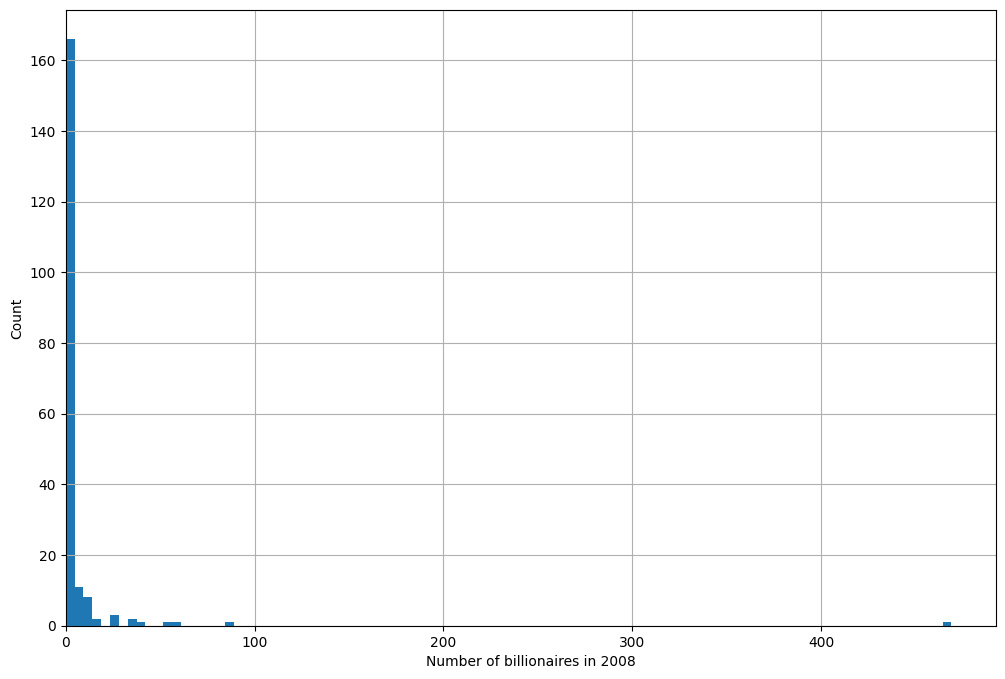

In [6]:
plt.subplots(figsize=(12, 8))
plt.hist(y, bins=100)
plt.xlim(left=0)
plt.grid()
plt.xlabel('Number of billionaires in 2008')
plt.ylabel('Count')
plt.show()

# Distribución Poisson

$f(y;\lambda)= \frac{{\lambda}^{y}}{y!} e^{-\lambda}$

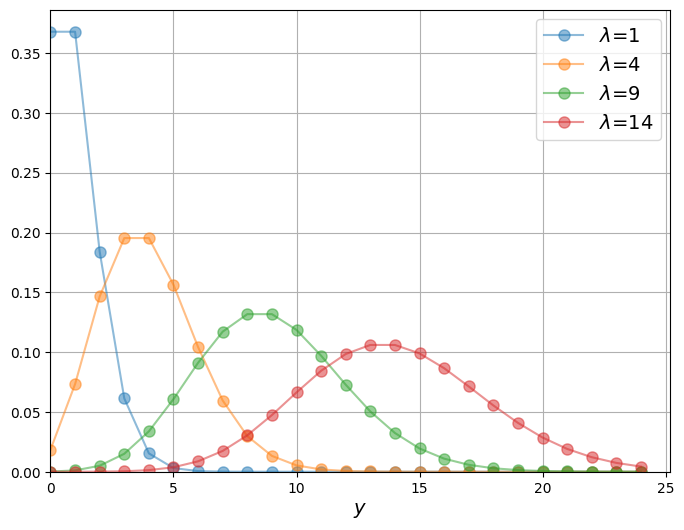

In [7]:
poisson_pmf = lambda y, 𝜆: 𝜆**y / factorial(y) * exp(-𝜆)
ys = range(0, 25)

fig, ax = plt.subplots(figsize=(8, 6))

for 𝜆 in [1, 4, 9, 14]:
    distribution = []
    for y_i in ys:
        distribution.append(poisson_pmf(y_i, 𝜆))
    ax.plot(ys,
            distribution,
            label=f'$\lambda$={𝜆}',
            alpha=0.5,
            marker='o',
            markersize=8)

ax.grid()
ax.set_xlabel('$y$', fontsize=14)
ax.axis(xmin=0, ymin=0)
ax.legend(fontsize=14)

plt.show()

$f(y;\lambda)= \frac{{\lambda}^{y}}{y!} e^{-\lambda}$

## Función de probabilidad condicional Poisson
El valor de $y_i$ condicionado a $X_i$, sigue una distribución de Poison
$f(y_i\mid x_i;\beta)= \frac{{\lambda_i}^{y_i}}{y_i!} e^{-\lambda_i} ~~~;~~~~ y_i = 0,1,2,...\infty$

donde el parametro $\lambda_i$ se calcula de la siguiente manera:

$\lambda_i=\exp(\beta_0+\beta_1x_{i1}+...+\beta_dx_{id})$

así $y_i$ es condicional a los valores de las $x_i$ y al vector $\beta$

Queremos encontrar $\beta$ que produce la máxima verosimilitud

In [8]:
X['const']=1
X

,PIB_percapita,lnpop,años_GATT,const
pais,,,,
United States,10.786021,19.532846,60,1
Canada,10.743365,17.319439,0,1
"Bahamas, The",10.072139,12.760934,0,1
Aruba,10.223734,11.526276,0,1
Bermuda,11.446847,11.086334,0,1
...,...,...,...,...
"Micronesia, Fed. Sts.",7.824408,11.556923,0,1
Samoa,8.124372,12.119665,15,1
"Hong Kong SAR, China",10.356964,15.755374,22,1


# Regresión Possion utilizando `statsmodels`

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=42)


In [10]:
poisson_reg = sm.Poisson(y_train, X_train).fit()
print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 1.759975
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:        num_billonarios   No. Observations:                  131
Model:                        Poisson   Df Residuals:                      127
Method:                           MLE   Df Model:                            3
Date:                Fri, 14 Feb 2025   Pseudo R-squ.:                  0.9113
Time:                        06:23:32   Log-Likelihood:                -230.56
converged:                       True   LL-Null:                       -2600.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
PIB_percapita     1.0681      0.033     32.145      0.000       1.003       1.133
lnpop             1.

<h3> Interpretación de los coeficientes <h3>

Al aumentar en 1 unidad la variable independiente, la `y` es la multiplicación de coeficiente exponenciado


In [11]:
poisson_predictions = poisson_reg.get_prediction(X_test)
poisson_predictions.summary_frame()

,predicted,se,ci_lower,ci_upper
pais,,,,
Turkey,12.559769,0.823713,11.044777,14.282571
Tanzania,0.484490,0.072636,0.361135,0.649979
St. Kitts and Nevis,0.001350,0.000369,0.000791,0.002305
Lithuania,0.430366,0.051585,0.340259,0.544335
Tajikistan,0.049655,0.007883,0.036377,0.067779
...,...,...,...,...
United Kingdom,49.846367,2.679661,44.861550,55.385074
Brazil,39.095807,2.230855,34.959046,43.722077
Niger,0.044145,0.008722,0.029971,0.065021


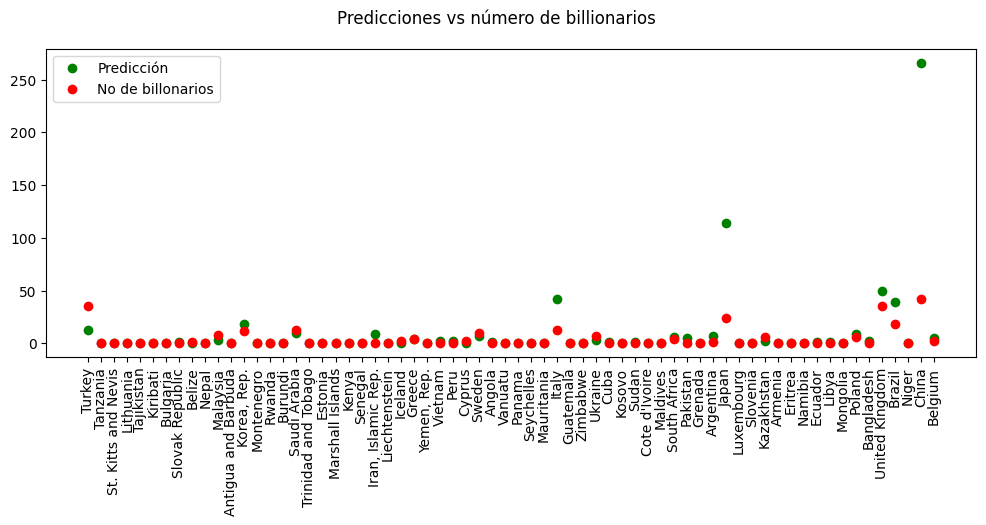

In [12]:
y_pred = poisson_predictions.summary_frame()['predicted']

fig = plt.figure(figsize=(12, 4))
fig.suptitle('Predicciones vs número de billionarios')
predicted, = plt.plot(y_test.index, y_pred, 'go', label='Predicción')
actual, = plt.plot(y_test.index, y_test, 'ro', label='No de billonarios')
plt.legend(handles=[predicted, actual])
plt.xticks(rotation=90)
plt.show()

Referencia:

[1] «The Poisson Regression Model», Time Series Analysis, Regression and Forecasting, 7 de junio de 2021. https://timeseriesreasoning.com/contents/poisson-regression-model/ (accedido 4 de agosto de 2022).

